# Operating Differentiation on Variables - with PyTorch Autograd
Written on 7/4/2024

In Nueral Network training, our most prior goal is to find the optimal points in domain which value loss function as minimal. For this goal, we execute differentiation with respect to each input variables on domain. PyTorch Autograd is one of well-known tools for this operation. 
The `autograd` package offers automatic differentiation for all operations involving Tensors. It operates as running from definition of function itself, meaning that backpropagation is defined by the way your code is defining the function from each variables.

Let's understand the Autograd function's principles and observe its tutorials to perform differentiation.

## Preliminary : Initialize Variables to Define Function
### Variable
The core class of the autograd package is `autograd.Variable`. This class wraps a `Tensor` and supports almost all the operations defined for Tensors. It provides access to the underlying raw tensor via the `.data` attribute, and the gradient with respect to this variable is accumulated in the `.grad` attribute, as illustrated in the following figure.

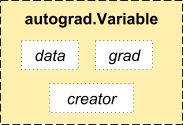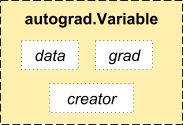

The Variable class also includes a *backward* method to perform backpropagation. After computing the function, you can call `.backward()` to automatically calculate all gradients. For instance, to backpropagate a loss function and train model parameter x, you use a variable loss to store the value computed by the loss function. By calling `loss.backward()`, PyTorch computes the gradients ∂loss/∂x for all trainable parameters and stores these gradient results in the corresponding variable x.

In [1]:
import torch
from torch.autograd import Variable

# Variables wrap a Tensor
x = Variable(torch.ones(2, 3), requires_grad=True)
# Variable containing:
# 1  1  1
# 1  1  1
# [torch.FloatTensor of size 2x3]

x.requires_grad = True #requires_grad indicates whether a variable is trainable.

### Function

Another crucial class for autograd implementation is Function. Variable and Function are interconnected, forming an acyclic graph that encodes the entire history of computation. Each variable has a `.grad_fn` attribute, which references the Function that created the Variable (This is not the Variables the user created, which have a grad_fn of None).

To compute derivatives, you can call `.backward()` on a Variable. If the Variable is a scalar which holds a single element, you don't need to provide any arguments to `backward()`. However, if it contains more elements, you must specify a `grad_output` argument, which is a tensor of the same shape.

The _backward_ method traverses the graph backward to compute the gradients. After this computation for one iteration, the graph is typically disposed of, although this behavior can be overridden with the `retain_graph` flag (though this is rarely recommended). For the next training iteration, a new graph is created.



In [2]:
y = x * x + 5           # Create y from an operation
# [torch.FloatTensor of size 2x3]
y

tensor([[6., 6., 6.],
        [6., 6., 6.]], grad_fn=<AddBackward0>)

## Get Gradient : Use `Autograd` to Differentiate the Variables 
Now, we can specify the `Autograd` function. There are many options as argument of this PyTorch function.

### Setting `requires_grad`
The `requires_grad` flag, which defaults to false unless wrapped in an nn.Parameter, allows for precise exclusion of subgraphs from gradient computation. It affects both the forward and backward passes:

- **Forward Pass**: An operation is recorded in the backward graph only if at least one of its input tensors requires gradients.
- **Backward Pass**: During the `.backward()` call, only leaf tensors with `requires_grad=True` will have their gradients accumulated in their .grad fields.

Although every tensor has this flag, it is meaningful to set it only for leaf tensors (those without a grad_fn e.g. the parameters of an nn.Module). Non-leaf tensors, which do have a grad_fn, are part of a backward graph and thus their gradients are necessary as intermediate results to compute gradients for leaf tensors that require gradients. Consequently, all non-leaf tensors automatically have `requires_grad=True`.

The `requires_grad` flag should be the primary method for controlling which parts of the model participate in gradient computation. For instance, to freeze parts of a pretrained model during fine-tuning, apply `.requires_grad_(False)` to the parameters that should not be updated. Since operations involving these parameters won't be recorded in the forward pass, their .grad fields won't be updated during the backward pass, effectively excluding them from the backward graph.

Because freezing parts of a model is a common requirement, `requires_grad` can also be set at the module level using `nn.Module.requires_grad_()`. When applied to a module, `.requires_grad_()` affects all of the module's parameters, which have `requires_grad=True` by default.

## Tutorials
We will compute gradient of polynomial function by `Autograd` function at given variable values, and compare this with the derivative values computed by hand.

Lets calculate the derivative value of $f(x) = 2x^{3} + 7x + 5$ at $x = 7$ by using `torch.autograd.grad()`.

**Step 1.** Import the torch library and initialize the input value `x` as a tensor and ensure that `requires_grad=True`.

In [3]:
import torch
x = torch.tensor([[1.0,2.0,3.0],[4.0,5.0,6.0]],requires_grad=True)
x


tensor([[1., 2., 3.],
        [4., 5., 6.]], requires_grad=True)

**Step 2.** Specify the function corresponding to the given mathematical equation $f(x) = 2x^{3} + 5x^{2} + 7x + 10$.



In [4]:
def f(x):
	return 2*(x**3) + 7*x + 5

print(f(x))


tensor([[ 14.,  35.,  80.],
        [161., 290., 479.]], grad_fn=<AddBackward0>)


**Step 3.** Let's create a variable `y` that represents the sum of values of $f$ by `f(x).sum()`. This summation process is required since derivative of $f$ at a given domain point can be measured by `torch.autograd.grad(outputs, input)` in which gradient can be implicitly created only for scalar outputs argument.

In [5]:
y = f(x).sum()
y


tensor(1059., grad_fn=<SumBackward0>)

**Step 4.** Use `torch.autograd.grad(y, x)` to do derivative operation on f(x) at the given x.



In [6]:
grad_f = torch.autograd.grad(y, x)
print(grad_f)


(tensor([[ 13.,  31.,  61.],
        [103., 157., 223.]]),)


In other way, we can use `.backward()` function as follows.

In [7]:
x = torch.tensor([[1.0,2.0,3.0],[4.0,5.0,6.0]],requires_grad=True)
y = f(x).sum()
y.backward()
print(x.grad)

tensor([[ 13.,  31.,  61.],
        [103., 157., 223.]])


Without `.sum()` process on $f$ in this `backward` function, we can alternatively take same shape of the loss funciton $f$ as the input variable for this function.

In [8]:
x = torch.tensor([[1.0,2.0,3.0],[4.0,5.0,6.0]],requires_grad=True)
f(x).backward(torch.ones_like(x))
print(x.grad)

tensor([[ 13.,  31.,  61.],
        [103., 157., 223.]])


To crosscheck the derivative of the above steps, let's take derivative on $f$ by hand.

In [9]:
df = 6*x**2 + 7
print(df)


tensor([[ 13.,  31.,  61.],
        [103., 157., 223.]], grad_fn=<AddBackward0>)


As we can see from above that the grad_f value and df are the same.



## Reference

[1] https://sebarnold.net/tutorials/beginner/blitz/autograd_tutorial.html <br>
[2] https://pytorch.org/docs/stable/notes/autograd.html#locally-disable-grad-doc <br>
[3] https://jhui.github.io/2018/02/09/PyTorch-Variables-functionals-and-Autograd <br>
[4] https://www.geeksforgeeks.org/how-to-differentiate-a-gradient-in-pytorch <br>
[5] https://pytorch.org/docs/stable/generated/torch.autograd.grad.html